In [35]:
# Importing the packages
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/newswav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/newswav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS =nltk.corpus.stopwords.words('english')

def clean_text(text):
    if not isinstance(text, str):
        if isinstance(text, (int, float)):  # Check if the input is numeric (int or float)
            text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stop words from text
    return text

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
/var/folders/by/vlfqqt093fn636d3sf0491mm0000gn/T/ipykernel_37137/2241928673.py:1: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')


In [37]:
fname='datasets/fakenewsnet.csv'
df = pd.read_csv(fname)
df['cleaned_text'] = df['text'].apply(clean_text)
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_text"], df['label'], test_size=0.2, random_state=123)


In [38]:
bow_vectorizer = CountVectorizer(min_df=5, ngram_range=(1,2), stop_words='english')
bow_x_train = bow_vectorizer.fit_transform(X_train)
bow_x_test = bow_vectorizer.transform(X_test)

In [39]:
count_vect_df = pd.DataFrame(bow_x_test.todense(),
columns=bow_vectorizer.get_feature_names_out())

In [40]:
log_reg= LogisticRegression(C=5, penalty='l2',max_iter=10000)
model=log_reg.fit(bow_x_train, y_train)
pred_lr = model.predict(bow_x_test)
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2122
           1       0.95      0.96      0.96      2038

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



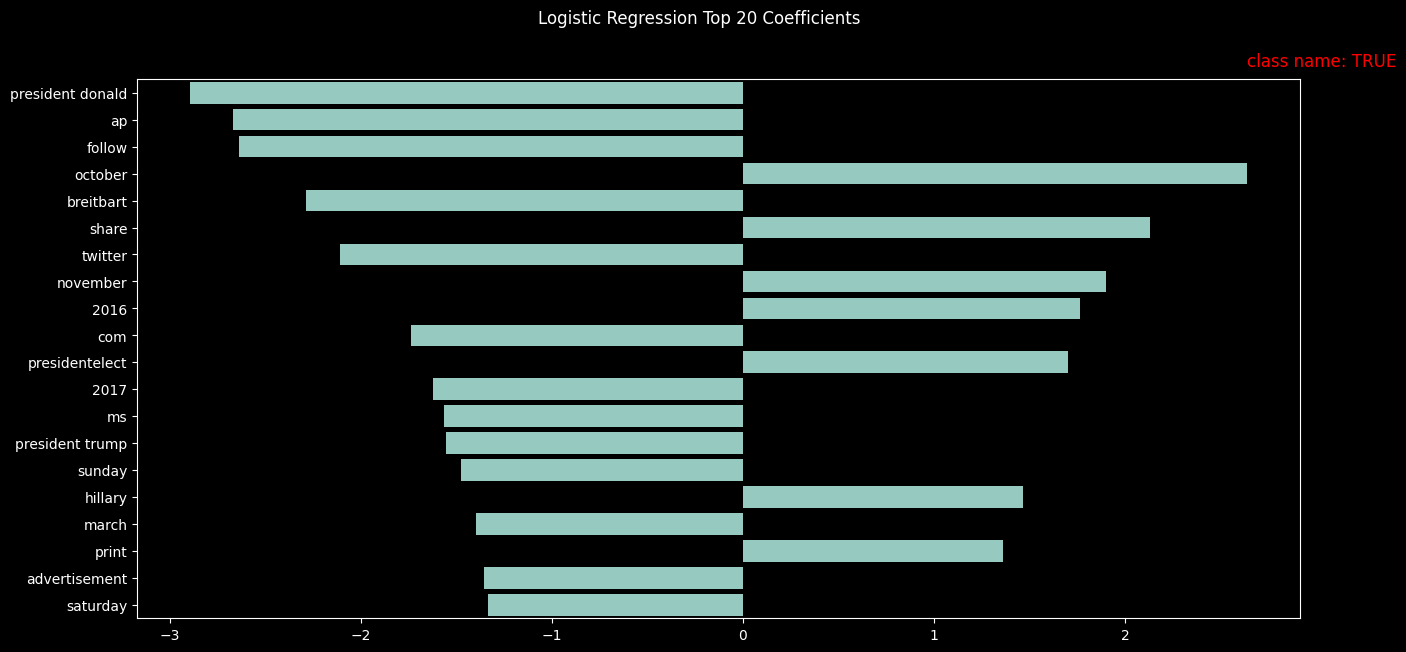

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('dark_background')
class_names = df["label"].unique()
n_features = 20
feature_names = bow_vectorizer.get_feature_names_out()

# Check dimensions of coefficients to handle both binary and multi-class cases appropriately
if model.coef_.shape[0] == 1:  # Binary classification, standard case
    # Only one set of coefficients; the second set is its negation
    coef_sets = [model.coef_[0], -model.coef_[0]]
    class_names = [0, 1]
else:
    coef_sets = [model.coef_[i] for i in range(len(class_names))]

logistic_reg_coef = coef_sets[0]
top_coef_index = np.argsort(np.abs(logistic_reg_coef))[::-1][:n_features]

fig = plt.figure(figsize=(15, 7))
sns.barplot(x=logistic_reg_coef[top_coef_index], y=np.array(feature_names)[top_coef_index])
plt.suptitle("Logistic Regression Top " + str(n_features) + " Coefficients", fontsize=12,
            fontweight="normal")
max_value = logistic_reg_coef[top_coef_index].max()
plt.text(max_value, -1, f'class name: TRUE', c='r', fontsize=12)
plt.show()


In [45]:
# Assuming you have already trained 'model' and have 'bow_vectorizer'
import shap

input_text = """

A baby rescued from her dying mother's womb after an Israeli air strike in southern Gaza has died, the BBC has learned.

Baby Sabreen al-Sakani was delivered by Caesarean section in a Rafah hospital shortly after midnight on Sunday.

Amid chaotic scenes doctors resuscitated the baby, using a hand pump to push air into her lungs.

However she died on Thursday and has been buried next to her mother after whom she was named.

Baby Sabreen was among 16 children killed in two air strikes in Rafah last weekend. All were killed in a bombardment targeting the housing complex where they lived. 

The Israel Defense Forces (IDF) said they were targeting Hamas fighters and infrastructure.

Sabreen's mother was seven-and-a-half months pregnant when the Israeli air strike on the al-Sakani family home took place just before midnight on Saturday as she, her husband Shukri and their three-year-old daughter Malak were asleep.
"""
# Create the SHAP explainer using the logistic regression model
explainer = shap.LinearExplainer(model, bow_vectorizer.transform(X_train))

# Transform the input text using the same BoW vectorizer
input_vector = bow_vectorizer.transform([input_text])

# Calculate SHAP values for the input text
shap_values = explainer.shap_values(input_vector)

if len(shap_values) == 2:  # Binary classification, two classes
    # Assuming class 1 is the class of interest
    shap_values = shap_values[1]
else:
    shap_values = shap_values[0]

# SHAP values can be used to plot the text explanation
shap_text_plot = shap.plots.text(shap_values)


AttributeError: 'numpy.ndarray' object has no attribute 'values'